In [1]:
# Trains Analysis
# Import required libraries for data processing and analysis
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [2]:
# Activate pandas conversion for R objects
pandas2ri.activate()

# Load RData file using R
base = importr('base')
base.load("Trains/trainsData.RData")

# Extract data objects from R environment
training_data_r = robjects.globalenv['trainingData']
test_data_r = robjects.globalenv['testData']
historical_congestion_r = robjects.globalenv['historicalCongestion']

def convert_historical_congestion(historical_congestion_r):
    """
    Convert historical congestion data from R format to pandas DataFrame.
    
    Parameters:
    historical_congestion_r (R object): Historical congestion data from R
    
    Returns:
    pandas.DataFrame: Processed historical congestion data with proper types
    """
    try:
        # Transpose data to get correct shape
        data = np.array(historical_congestion_r).T
        
        # Get column names from R object
        column_names = list(historical_congestion_r.colnames)
        
        # Create pandas DataFrame with proper column names
        df = pd.DataFrame(data, columns=column_names)
        
        # Convert data types
        df['Day'] = df['Day'].astype(str)
        df['Hour'] = df['Hour'].astype(int)
        
        # Convert numerical columns to float
        numeric_columns = [col for col in df.columns if col not in ['Day', 'Hour']]
        df[numeric_columns] = df[numeric_columns].astype(float)
        
        return df
        
    except Exception as e:
        print(f"Error converting historical congestion data: {str(e)}")
        raise
    
def convert_train_data(training_data_r):
    """
    Convert train data from R format to pandas DataFrame, preserving all features.
    
    Parameters:
    training_data_r (R object): Train timing data from R
    
    Returns:
    pandas.DataFrame: Complete train data with all original features
    """
    train_data_list = []
    
    for train in training_data_r:
        try:
            # Extract all components of train data
            timings_data = train[0]
            congestion_data = train[1]
            arrival_data = train[2]
            
            # Get column names for each component
            timing_cols = list(timings_data.names)
            congestion_cols = list(congestion_data.names)
            arrival_cols = list(arrival_data.names)
            
            # Create a dictionary for all timing features
            timing_dict = {}
            for i, col in enumerate(timing_cols):
                timing_dict[f"timing_{col}"] = [val for val in timings_data[i]]
            
            # Create a dictionary for all congestion features
            congestion_dict = {}
            for i, col in enumerate(congestion_cols):
                congestion_dict[f"congestion_{col}"] = congestion_data[i][0]
            
            # Create a dictionary for all arrival features (if available)
            arrival_dict = {}
            if len(arrival_data) > 0:
                for i, col in enumerate(arrival_cols):
                    arrival_dict[f"arrival_{col}"] = arrival_data[i][0]
            
            # Combine all features
            train_info = {**timing_dict, **congestion_dict, **arrival_dict}
            train_data_list.append(train_info)
            
        except Exception as e:
            print(f"Error processing train data: {str(e)}")
            continue
    
    return pd.DataFrame(train_data_list)

def process_features(df):
    """
    Process and engineer features for train delay prediction.
    
    Parameters:
    df (pandas.DataFrame): Raw train data
    
    Returns:
    pandas.DataFrame: Processed data with engineered features
    """
    # Create a copy to avoid modifying the original dataframe
    df = df.copy()
    
    # Extract fourth elements from list columns first
    list_columns = [
        'timing_departure.time',
        'timing_departure.schedule',
        'timing_arrival.time',
        'timing_arrival.schedule',
        'timing_day.week'
    ]
    
    for col in list_columns:
        df[col] = df[col].apply(lambda x: x[-1])
    
    # Convert time strings to seconds
    def time_to_seconds(time_str):
        hours, minutes, seconds = map(int, time_str.split(':'))
        return hours * 3600 + minutes * 60 + seconds
    
    # Create time-based features
    df['departure_delay'] = df.apply(lambda x: 
        time_to_seconds(x['timing_departure.time']) - time_to_seconds(x['timing_departure.schedule']), axis=1)
    
    df['arrival_delay'] = df.apply(lambda x: 
        time_to_seconds(x['timing_arrival.time']) - time_to_seconds(x['timing_arrival.schedule']), axis=1)
    
    # Extract hour information from the already processed departure time
    df['hour'] = df['timing_departure.time'].apply(lambda x: int(x.split(':')[0]))
    
    # Convert days to numerical features - assuming timing_day.week contains the day information
    df['day_of_week'] = pd.Categorical(df['timing_day.week'].apply(lambda x: x[3])).codes
    
    # Create peak hour indicator
    df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if (6 <= x <= 9) or (16 <= x <= 19) else 0)
    
    # Calculate average station delays
    df['avg_station_delay'] = (df['congestion_Leeds.av.delay'] + 
                              df['congestion_Sheffield.av.delay'] + 
                              df['congestion_Nottingham.av.delay']) / 3
    
    # Calculate total congestion
    df['total_congestion'] = (df['congestion_Leeds.trains'] + 
                             df['congestion_Sheffield.trains'] + 
                             df['congestion_Nottingham.trains'])
    
    return df

def train_delay_model(df):
    """
    Train a random forest model for predicting train delays.
    
    Parameters:
    df (pandas.DataFrame): Processed train data
    
    Returns:
    tuple: (trained model, scaler, RMSE score, feature list)
    """
    # Select features for modeling
    features = ['day_of_week', 'departure_delay', 'arrival_delay',
               'congestion_Leeds.trains', 'congestion_Leeds.av.delay',
               'congestion_Sheffield.trains', 'congestion_Sheffield.av.delay',
               'hour', 'is_peak_hour', 'avg_station_delay', 'total_congestion']
    
    X = df[features]
    y = df['arrival_delay.secs']
    
    # Split data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Train model using linear regression
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    # Evaluate model
    val_predictions = model.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, val_predictions))
    
    return model, scaler, rmse, features

In [3]:
historical_df = convert_historical_congestion(historical_congestion_r)
train_df = convert_train_data(training_data_r)

## EDA

KeyError: 'network_congestion_impact'

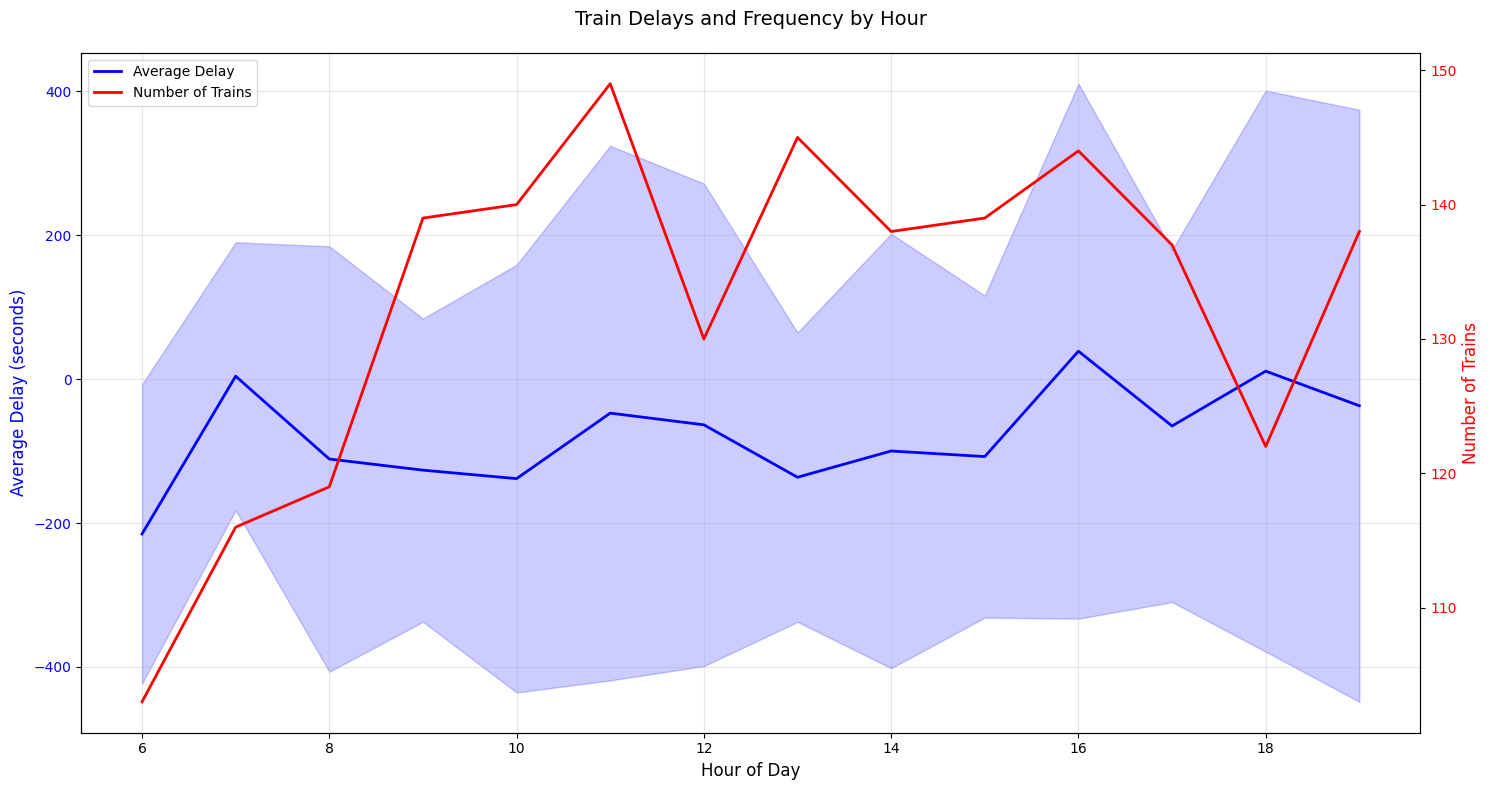

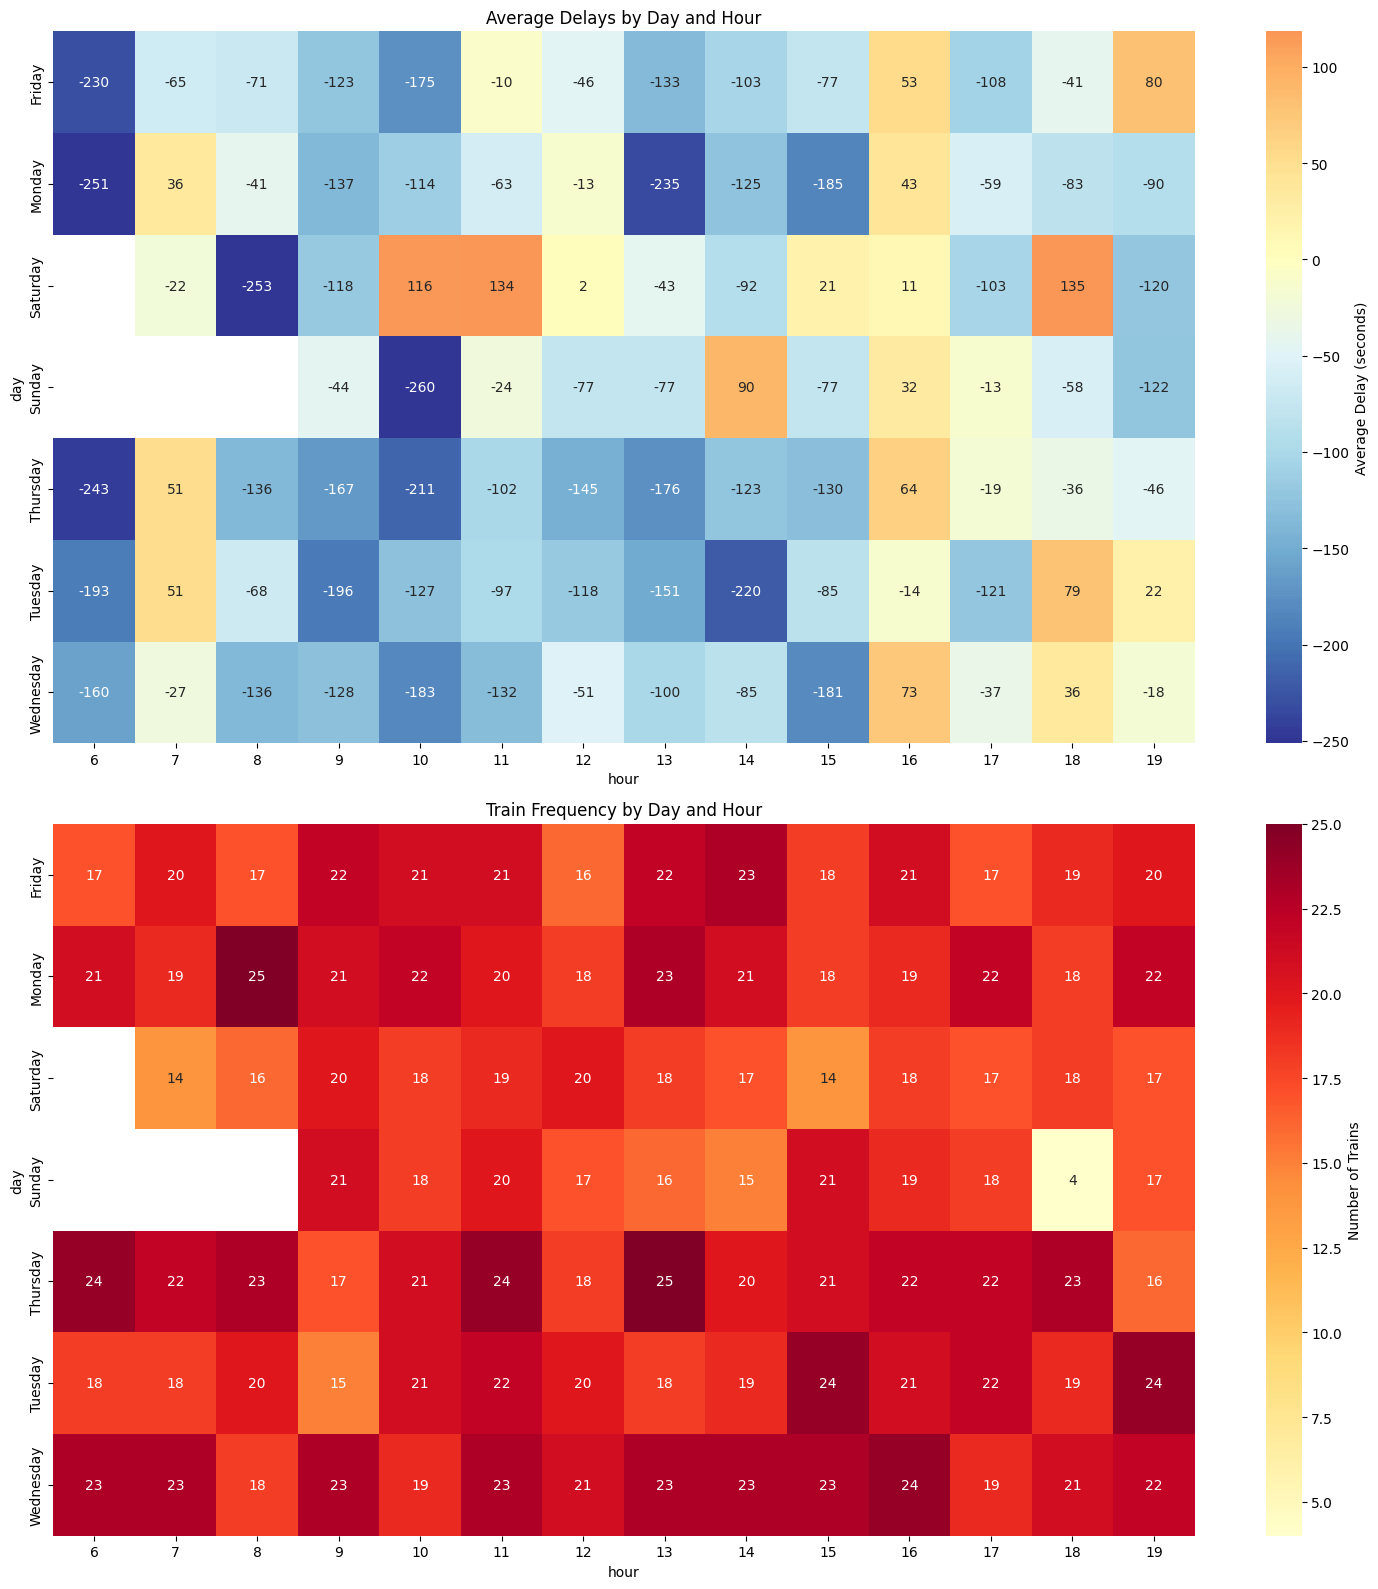

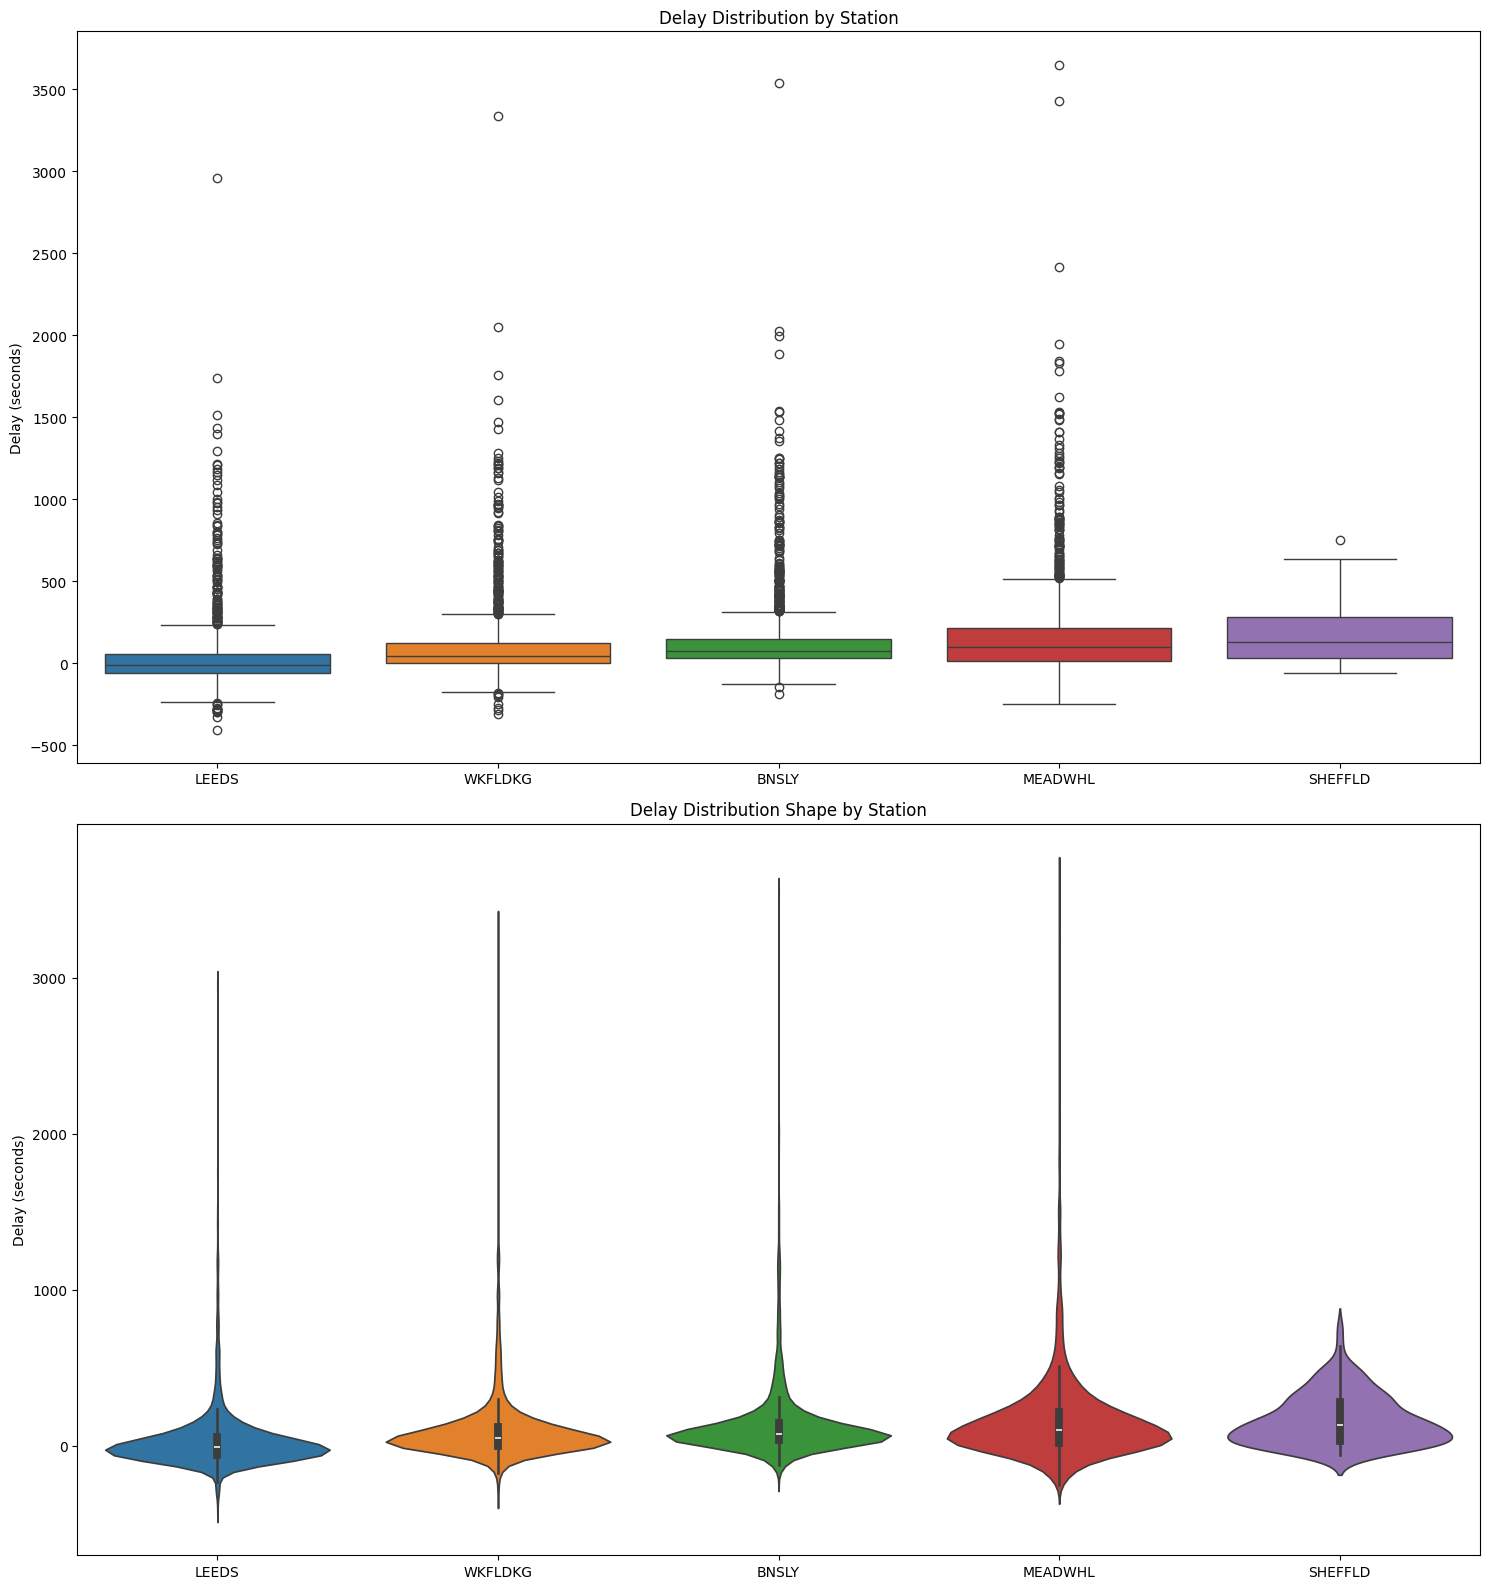

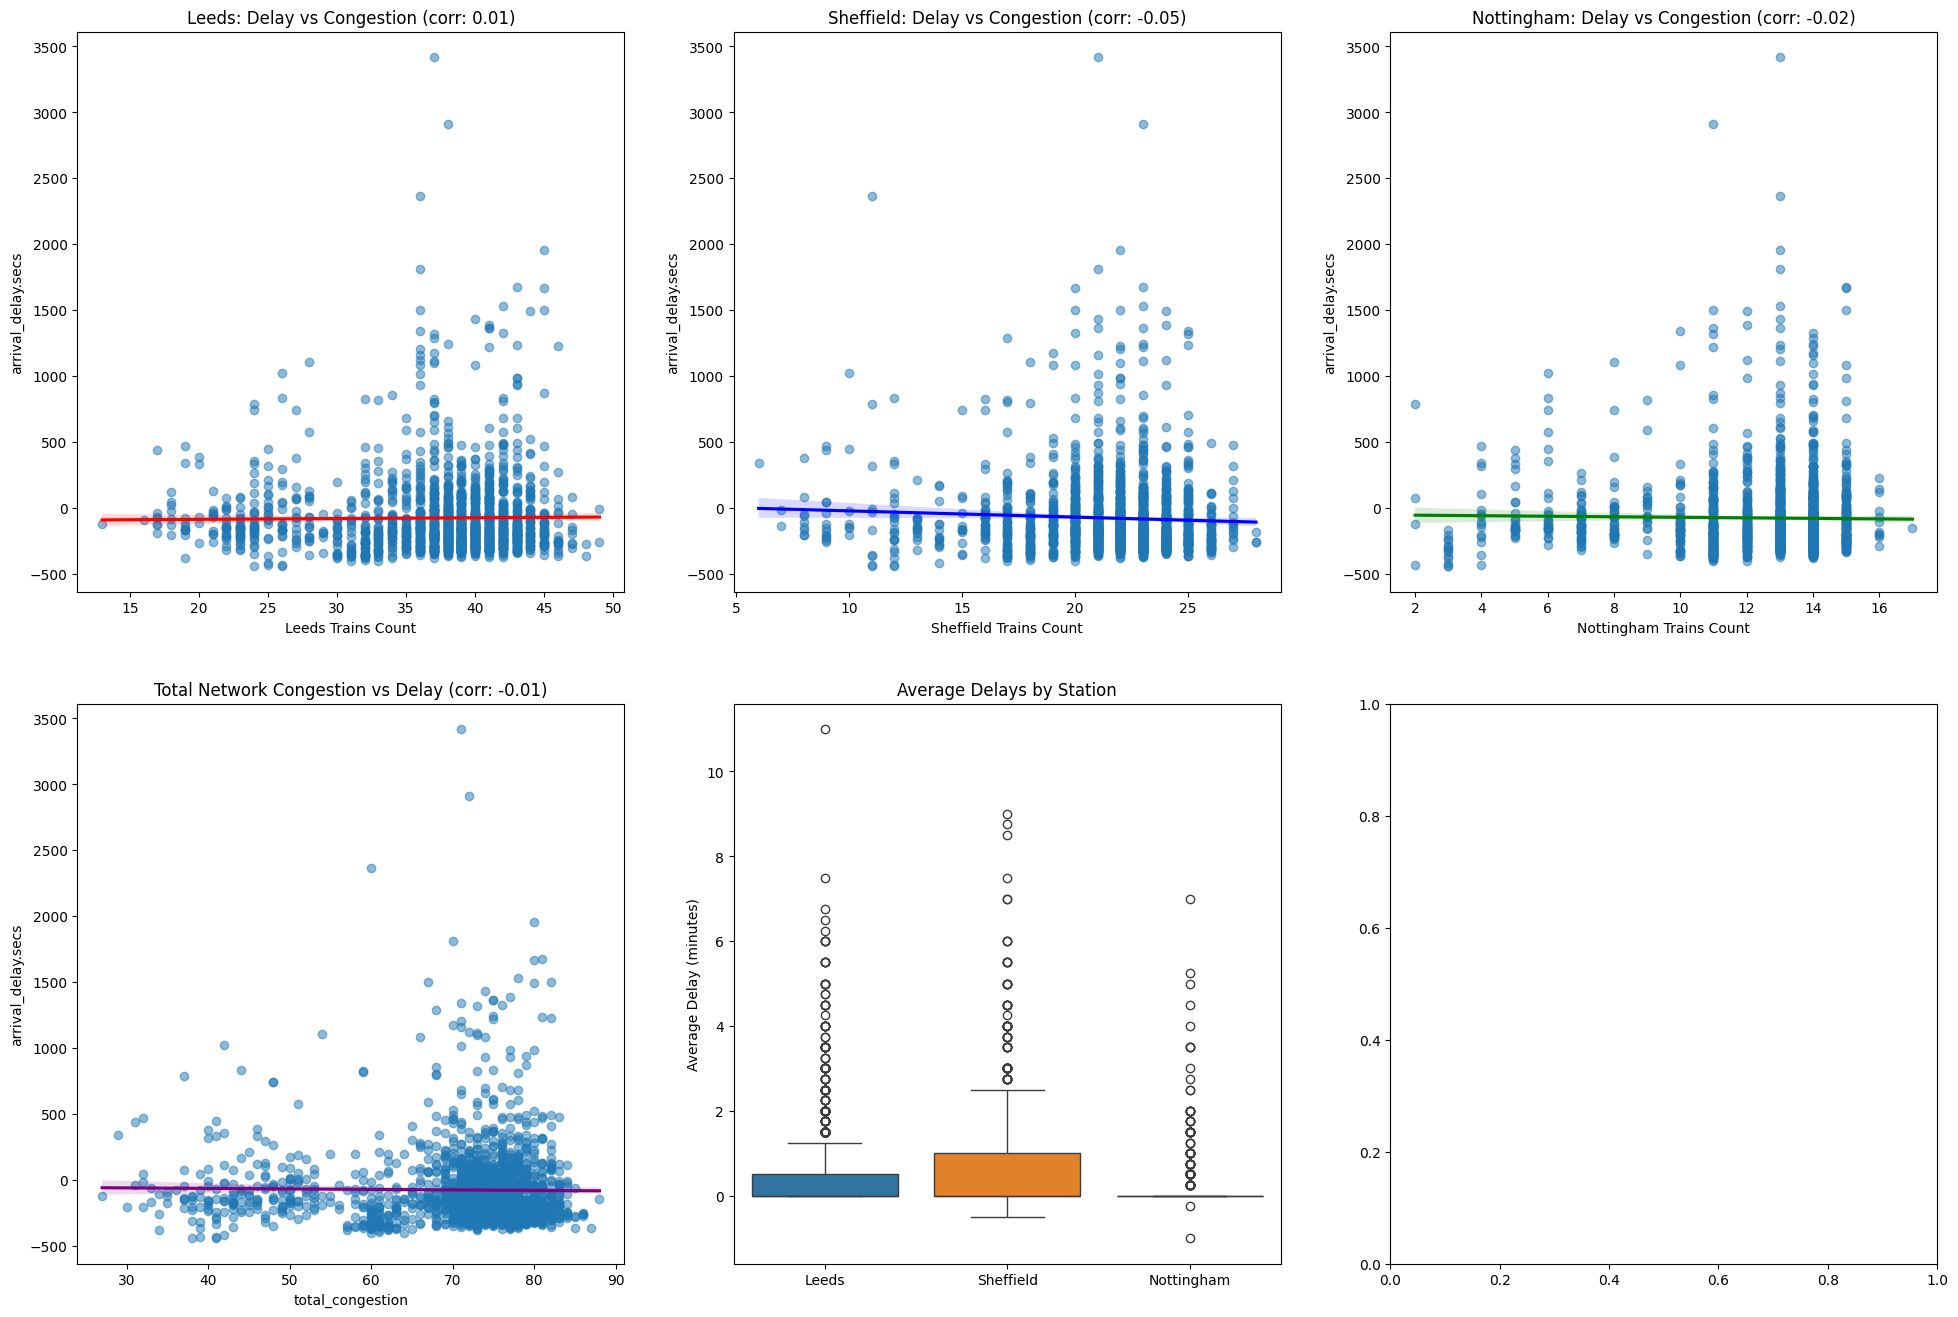

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create day and hour combinations
train_df['day'] = train_df['timing_day.week'].apply(lambda x: x[0])
train_df['hour'] = train_df['timing_departure.time'].apply(lambda x: int(x[0].split(':')[0]))

def create_detailed_time_series(train_df):
    # Create figure with larger size and better resolution
    fig, ax1 = plt.subplots(figsize=(15, 8), dpi=100)
    
    # Calculate hourly metrics
    hourly_stats = train_df.groupby('hour').agg({
        'arrival_delay.secs': ['mean', 'std', 'count']
    }).round(2)
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Plot mean delays with confidence interval
    line1 = ax1.plot(hourly_stats.index, 
                     hourly_stats[('arrival_delay.secs', 'mean')], 
                     'b-', linewidth=2, label='Average Delay')
    
    # Add confidence interval
    std_dev = hourly_stats[('arrival_delay.secs', 'std')]
    mean_val = hourly_stats[('arrival_delay.secs', 'mean')]
    ax1.fill_between(hourly_stats.index, 
                     mean_val - std_dev, 
                     mean_val + std_dev, 
                     alpha=0.2, color='b')
    
    # Plot train frequency
    line2 = ax2.plot(hourly_stats.index, 
                     hourly_stats[('arrival_delay.secs', 'count')], 
                     'r-', linewidth=2, label='Number of Trains')
    
    # Customize axes
    ax1.set_xlabel('Hour of Day', fontsize=12)
    ax1.set_ylabel('Average Delay (seconds)', color='b', fontsize=12)
    ax2.set_ylabel('Number of Trains', color='r', fontsize=12)
    
    # Add grid and customize ticks
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='y', labelcolor='b')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add title and legend
    plt.title('Train Delays and Frequency by Hour', fontsize=14, pad=20)
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    return fig

def create_detailed_heatmap(train_df):
    # Create pivot table with multiple metrics
    delay_matrix = train_df.pivot_table(
        values='arrival_delay.secs',
        index='day',
        columns='hour',
        aggfunc=['mean', 'count', 'std']
    )
    
    # Create a figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
    
    # Plot mean delays heatmap
    sns.heatmap(delay_matrix['mean'].round(0), 
                ax=ax1,
                cmap='RdYlBu_r',
                center=0,
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Average Delay (seconds)'},
                robust=True)
    ax1.set_title('Average Delays by Day and Hour')
    
    # Plot frequency heatmap
    sns.heatmap(delay_matrix['count'], 
                ax=ax2,
                cmap='YlOrRd',
                annot=True,
                fmt='.0f',
                cbar_kws={'label': 'Number of Trains'})
    ax2.set_title('Train Frequency by Day and Hour')
    
    plt.tight_layout()
    return fig

def create_detailed_station_analysis(train_df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
    
    # Calculate station delays
    def get_station_delay(row):
        delays = []
        for sched, actual in zip(row['timing_arrival.schedule'], 
                               row['timing_arrival.time']):
            sched_sec = sum(int(x) * 60 ** i for i, x in 
                          enumerate(reversed(sched.split(':'))))
            actual_sec = sum(int(x) * 60 ** i for i, x in 
                           enumerate(reversed(actual.split(':'))))
            delays.append(actual_sec - sched_sec)
        return delays
    
    station_delays = pd.DataFrame([get_station_delay(row) 
                                 for _, row in train_df.iterrows()],
                                columns=['LEEDS', 'WKFLDKG', 'BNSLY', 
                                       'MEADWHL', 'SHEFFLD'])
    
    # Box plot
    sns.boxplot(data=station_delays, ax=ax1)
    ax1.set_title('Delay Distribution by Station')
    ax1.set_ylabel('Delay (seconds)')
    
    # Violin plot for more detailed distribution
    sns.violinplot(data=station_delays, ax=ax2)
    ax2.set_title('Delay Distribution Shape by Station')
    ax2.set_ylabel('Delay (seconds)')
    
    plt.tight_layout()
    return fig

def create_complete_congestion_analysis(train_df):
    fig, axes = plt.subplots(2, 3, figsize=(24, 16))  # Change to 2 rows and 3 columns
    
    # Define all stations for analysis
    stations = ['Leeds', 'Sheffield', 'Nottingham']
    colors = ['red', 'blue', 'green']
    
    for idx, (station, color) in enumerate(zip(stations, colors)):
        # Scatter plot for each station
        sns.regplot(data=train_df,
                   x=f'congestion_{station}.trains',
                   y='arrival_delay.secs',
                   ax=axes[0, idx],
                   scatter_kws={'alpha':0.5},
                   line_kws={'color': color})
        
        corr = train_df[f'congestion_{station}.trains'].corr(train_df['arrival_delay.secs'])
        axes[0, idx].set_title(f'{station}: Delay vs Congestion (corr: {corr:.2f})')
        axes[0, idx].set_xlabel(f'{station} Trains Count')
    
    # Analysis in the second row
    # 1. Overall congestion analysis
    train_df['total_congestion'] = (train_df['congestion_Leeds.trains'] + 
                                   train_df['congestion_Sheffield.trains'] + 
                                   train_df['congestion_Nottingham.trains'])
    
    sns.regplot(data=train_df,
                x='total_congestion',
                y='arrival_delay.secs',
                ax=axes[1, 0],
                scatter_kws={'alpha':0.5},
                line_kws={'color': 'purple'})
    total_corr = train_df['total_congestion'].corr(train_df['arrival_delay.secs'])
    axes[1, 0].set_title(f'Total Network Congestion vs Delay (corr: {total_corr:.2f})')
    
    # 2. Impact of average delays
    network_delays = pd.DataFrame({
        'Leeds': train_df['congestion_Leeds.av.delay'],
        'Sheffield': train_df['congestion_Sheffield.av.delay'],
        'Nottingham': train_df['congestion_Nottingham.av.delay']
    })
    
    sns.boxplot(data=network_delays, ax=axes[1, 1])
    axes[1, 1].set_title('Average Delays by Station')
    axes[1, 1].set_ylabel('Average Delay (minutes)')
    
    # 3. Cumulative delay effect
    # Create composite congestion measure including average delays
    train_df['network_congestion_impact'] = (
        train_df['congestion_Leeds.av.delay'] +
        train_df['congestion_Sheffield.av.delay'] +
        train_df['congestion_Nottingham.av.delay']
    ) / 3.0
    # Create categories for network congestion impact
    train_df['congestion_impact_category'] = pd.qcut(
        train_df['network_congestion_impact'],
        q=5,
        labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
    )
    
    sns.boxplot(data=train_df,
                x='congestion_impact_category',
                y='arrival_delay.secs',
                ax=axes[1, 2])
    axes[1, 2].set_title('Delay Distribution by Network Congestion Level')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig


def create_detailed_trend_analysis(train_df, window_sizes=[3, 5, 10]):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))
    
    # Sort by hour
    hourly_delays = train_df.groupby('hour')['arrival_delay.secs'].mean()
    
    # Plot raw data
    ax1.plot(hourly_delays.index, hourly_delays.values, 
             'k-', alpha=0.3, label='Raw Data')
    
    # Plot multiple rolling averages
    colors = ['b', 'g', 'r']
    for window, color in zip(window_sizes, colors):
        rolling_avg = hourly_delays.rolling(window=window, center=True).mean()
        ax1.plot(rolling_avg.index, rolling_avg.values, 
                f'{color}-', linewidth=2, 
                label=f'{window}-Hour Rolling Average')
    
    ax1.set_title('Delay Trends with Multiple Rolling Averages')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add decomposition plot
    from scipy import signal
    trend = signal.savgol_filter(hourly_delays.values, 
                                window_length=5, 
                                polyorder=2)
    residuals = hourly_delays.values - trend
    
    ax2.plot(hourly_delays.index, trend, 'g-', label='Trend')
    ax2.plot(hourly_delays.index, residuals, 'r-', alpha=0.5, label='Residuals')
    ax2.set_title('Trend-Residual Decomposition')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Create all plots
time_series_fig = create_detailed_time_series(train_df)
heatmap_fig = create_detailed_heatmap(train_df)
station_fig = create_detailed_station_analysis(train_df)
congestion_fig = create_complete_congestion_analysis(train_df)
trend_fig = create_detailed_trend_analysis(train_df)

# Save plots
"""
time_series_fig.savefig('time_series_analysis.png', dpi=300, bbox_inches='tight')
heatmap_fig.savefig('heatmap_analysis.png', dpi=300, bbox_inches='tight')
station_fig.savefig('station_analysis.png', dpi=300, bbox_inches='tight')
congestion_fig.savefig('congestion_analysis.png', dpi=300, bbox_inches='tight')
trend_fig.savefig('trend_analysis.png', dpi=300, bbox_inches='tight')
"""
